In [5]:
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [6]:
# Load the envionmental variables
df_env = pd.read_csv("../../Input/environ_all.csv", index_col=0)

# Load ecosystem data
ecosystem = pd.read_csv("../../Input/ecosystem.csv", index_col=0)
ecosystem = ecosystem[ecosystem['Ecosystem_recode'] != 'Unknown']

# Load Shannon-Wienner diversity data for all OTUs, abundant and rare taxa, and generalists and specialists
shannon_all = pd.read_csv("../../Input/OTU_shannon_vector.tsv",sep="\t", index_col=0).rename(columns={"shannon":"All taxa"})
shannon_group = pd.read_csv("../../Input/ecotypes_shannon.csv", index_col=0)

df_shannon = pd.merge(shannon_all, shannon_group, left_index = True, right_index = True)

# Load Weighted Unifraq diversity data for all OTUs, abundant and rare taxa, and generalists and specialists
df_unifraq_all = pd.read_csv("../../Input/OTU_weighted_unifrac_distance_matrix.tsv",sep="\t", index_col=0)
df_unifraq_abun = pd.read_csv("../../Input/weighted_unifrac_abun.csv",index_col=0)
df_unifraq_rare = pd.read_csv("../../Input/weighted_unifrac_rare.csv",index_col=0)
df_unifraq_gen = pd.read_csv("../../Input/weighted_unifrac_gen.csv",index_col=0)
df_unifraq_spe = pd.read_csv("../../Input/weighted_unifrac_spe.csv",index_col=0)

# Spearman correlations btw environemntal variables & Shannon diversity

In [7]:
# perform spearman corelation between environmental variables and one Shannon diversity variable
def spearman_corr(env_var, diversity):
    env_var_list=[]
    corr_coeff_list=[]
    p_value_list= []
    env_div = pd.merge(diversity, env_var, left_index=True, right_index=True)
    for i in env_div.iloc[:,1:].columns:
        res = stats.spearmanr(env_div.iloc[:, 0], env_div[i], nan_policy='omit')
        env_var_list.append(i)
        corr_coeff_list.append(res.statistic)
        p_value_list.append(res.pvalue)
    environment_corr_df = pd.DataFrame({'env_var':env_var_list,'spearmanr':corr_coeff_list,'pvalue':p_value_list})
    return environment_corr_df

### Ecotypes

In [8]:
# prepare concatenated  dataframe with spearman correlation results for all ecotypes

env_corr_all = pd.DataFrame()

for group, data in df_shannon.items():
    env_corr_df = spearman_corr(df_env, df_shannon[[group]])
    env_corr_df['adjusted_pvalue'] = fdrcorrection(env_corr_df['pvalue'], alpha=0.05, method='indep', is_sorted=False)[1]

    conditions = [
    env_corr_df['adjusted_pvalue']< 0.0001,
    env_corr_df['adjusted_pvalue']< 0.001,
    env_corr_df['adjusted_pvalue']< 0.01,
    env_corr_df['adjusted_pvalue']< 0.05,
    env_corr_df['adjusted_pvalue']>= 0.05
    ]
    choices = ['****','***','**','*','']
    env_corr_df['asterisk'] = np.select(conditions, choices, default=0)
    env_corr_df['Group'] = group
    env_corr_all = pd.concat([env_corr_all, env_corr_df])


In [9]:
# prepare a pivot table for spearman correlation coefficient and a pivot table for significant levels

table = pd.pivot_table(env_corr_all, values=['spearmanr'], index=['env_var'], columns=['Group'], sort=False)
table.columns = table.columns.droplevel()

annot = pd.pivot(env_corr_all, values=['asterisk'], index=['env_var'], columns=['Group'])
annot = annot.reindex(table.index)
annot.columns = annot.columns.droplevel()
annot = annot[table.columns]

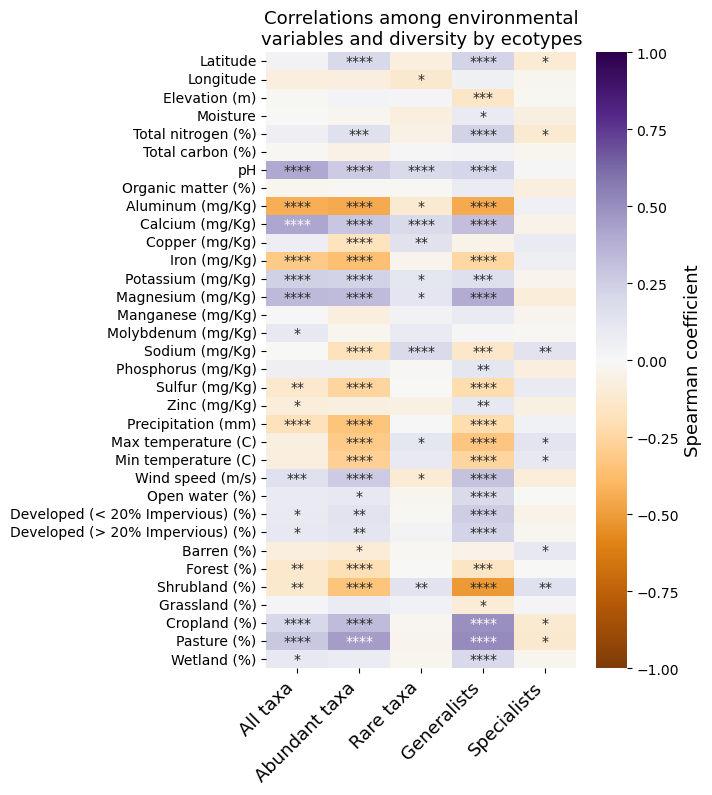

In [10]:
plt.rcParams["figure.figsize"] = (5, 8)
fig, ax = plt.subplots()
sns.heatmap(table, annot=annot, vmin=-1, vmax=1, fmt="", cmap='PuOr', cbar_kws={'label': 'Spearman coefficient'}, ax=ax)
ax.figure.axes[-1].yaxis.label.set_size(13)
yticks = ax.get_yticklabels()
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right', size=13)
ax.set_title('Correlations among environmental\nvariables and diversity by ecotypes', fontsize=13)
plt.savefig('../output/env_ecotypes_cor.pdf', bbox_inches='tight', dpi = 300)
plt.show()

### Ecosystems

In [11]:
# prepare concatenated  dataframe with spearman correlation results for ecosystems

ecosystem_dict = defaultdict(list)

for index, row in ecosystem.iterrows():
    eco = row['Ecosystem_recode']
    ecosystem_dict[eco].append(index)

env_corr_ecosys = pd.DataFrame()

for key in ecosystem_dict:
    shannon_eco = shannon_all[shannon_all.index.isin(ecosystem_dict[key])]
    env_corr_df = spearman_corr(df_env, shannon_eco)
    env_corr_df['adjusted_pvalue'] = fdrcorrection(env_corr_df['pvalue'], alpha=0.05, method='indep', is_sorted=False)[1]

    conditions = [
    env_corr_df['adjusted_pvalue']< 0.0001,
    env_corr_df['adjusted_pvalue']< 0.001,
    env_corr_df['adjusted_pvalue']< 0.01,
    env_corr_df['adjusted_pvalue']< 0.05,
    env_corr_df['adjusted_pvalue']>= 0.05
    ]
    choices = ['****','***','**','*','']
    env_corr_df['asterisk'] = np.select(conditions, choices, default=0)
    env_corr_df['Group'] = key
    env_corr_ecosys = pd.concat([env_corr_ecosys, env_corr_df])

In [12]:
# prepare a pivot table for spearman correlation coefficient and a pivot table for significant levels

table = pd.pivot_table(env_corr_ecosys, values=['spearmanr'], index=['env_var'], columns=['Group'], sort=False)
table.columns = table.columns.droplevel()

annot = pd.pivot(env_corr_ecosys, values=['asterisk'], index=['env_var'], columns=['Group'])
annot = annot.reindex(table.index)
annot.columns = annot.columns.droplevel()
annot = annot[table.columns]

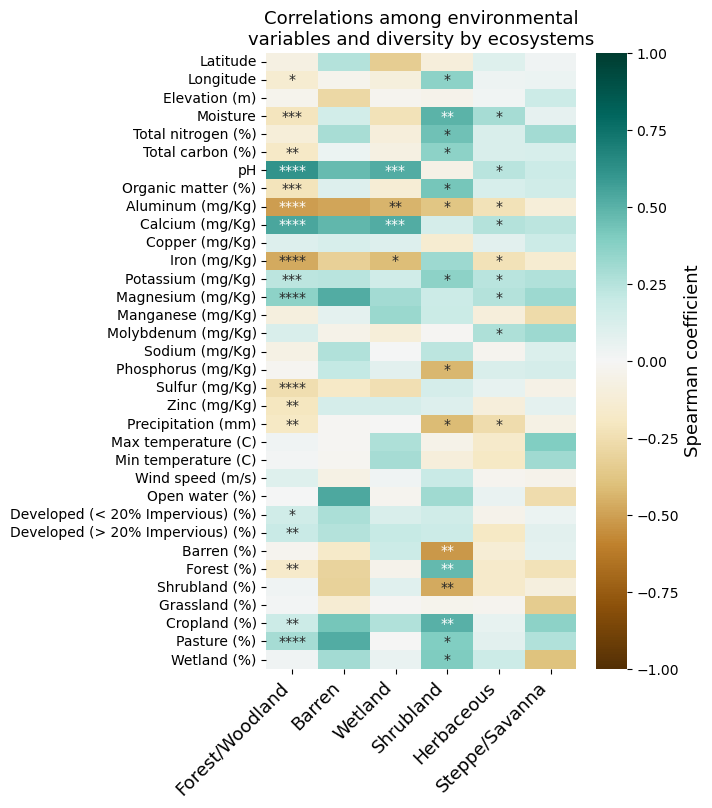

In [13]:
plt.rcParams["figure.figsize"] = (5, 8)
fig, ax = plt.subplots()
sns.heatmap(table, annot=annot, vmin=-1, vmax=1, fmt="", cmap='BrBG', cbar_kws={'label': 'Spearman coefficient'}, ax=ax)
ax.figure.axes[-1].yaxis.label.set_size(13)
yticks = ax.get_yticklabels()
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right', size=13)
ax.set_title('Correlations among environmental\nvariables and diversity by ecosystems', fontsize=13)
plt.savefig('../output/env_ecosystems_cor.pdf', bbox_inches='tight', dpi = 300)
plt.show()

# VPA for environmnetal variables

Run VPA using R script "VarPart_microgroups.R" and "VarPart_ecosystems.R"

In [7]:
# Prepare input files for VarPart_microgroups.R for ecotypes
df_env_sub = df_env.sort_index().dropna()
df_shannon = df_shannon.sort_index()
common_index = df_env_sub.index.intersection(df_shannon.index)
df_env_sub = df_env_sub[df_env_sub.index.isin(common_index)]
df_shannon = df_shannon[df_shannon.index.isin(common_index)]

df_shannon.to_csv("../../Input/VPA/shannon_VPA.csv")
df_env_sub.to_csv("../../Input/VPA/env_VPA.csv")

In [23]:
# Prepare input files for VarPart_ecosystems.R for ecosystems

ecosystem_dict = defaultdict(list)

for index, row in ecosystem.iterrows():
    eco = row['Ecosystem_recode'].split('/')[0]
    ecosystem_dict[eco].append(index)

env_sorted = df_env.sort_index().dropna()
shannon_all_sorted = shannon_all.sort_index()

for key in ecosystem_dict:
    df_env_sub = env_sorted[env_sorted.index.isin(ecosystem_dict[key])]
    df_shannon_all = shannon_all_sorted[shannon_all_sorted.index.isin(ecosystem_dict[key])]
    common_index = df_env_sub.index.intersection(df_shannon_all.index)
    df_env_sub = df_env_sub[df_env_sub.index.isin(common_index)]
    df_shannon_all = df_shannon_all[df_shannon_all.index.isin(common_index)]
    df_env_sub.to_csv("../../Input/VPA/env_VPA_" + key + ".csv")
    df_shannon_all.to_csv("../../Input/VPA/shannon_VPA_" + key + ".csv")

# Distance decay analysis

In [61]:
# Function to calculate geographic distances for all pairwise samples
def calculate_distances(df):
    n = len(df)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            loc1 = (df.iloc[i]['Latitude'], df.iloc[i]['Longitude'])
            loc2 = (df.iloc[j]['Latitude'], df.iloc[j]['Longitude'])
            distance = geodesic(loc1, loc2).kilometers
            distance_matrix[i, j] = distance_matrix[j, i] = distance
    return pd.DataFrame(distance_matrix, index=df.index, columns=df.index)


In [62]:
# load environmental data
df_env = pd.read_csv("../../Input/environ_all.csv", index_col=0)
df_env = df_env.sort_index() # sort the index so that the order of samples in the env data matches with that in the unifrac distance data
df_distance = calculate_distances(df_env)

In [63]:
# load weighted unifrac distance matrix for all and each ecotype
unifrac_all = pd.read_csv('../../Input/OTU_weighted_unifrac_distance_matrix.tsv',sep='\t', index_col=0)
unifrac_abun = pd.read_csv('../../Input/weighted_unifrac_abun.csv', index_col=0)
unifrac_rare = pd.read_csv('../../Input/weighted_unifrac_rare.csv', index_col=0)
unifrac_gen = pd.read_csv('../../Input/weighted_unifrac_gen.csv', index_col=0)
unifrac_spe = pd.read_csv('../../Input/weighted_unifrac_spe.csv', index_col=0)

In [64]:
# Function to melt the distance matrix

def melt_distance_matrix(df_distance, distance_name):
    dist_melted = df_distance.where(np.triu(np.ones(df_distance.shape)).astype(bool)) # get upper triangle distance
    dist_melted = dist_melted.melt(ignore_index=False).dropna()
    dist_melted.index.name = 'Sample i'
    dist_melted.columns = ['Sample j', distance_name]
    dist_melted = dist_melted.reset_index()
    dist_melted = dist_melted[dist_melted[distance_name] != 0]

    return dist_melted

In [65]:
# Get melted geographic distance
geo_dist_melted = melt_distance_matrix(df_distance, 'Geo')

In [66]:
# Get melted weighted unifrac distance for each ecotype
unifrac_all_melted = melt_distance_matrix(unifrac_all, 'Unifrac')
unifrac_abun_melted = melt_distance_matrix(unifrac_abun, 'Unifrac')
unifrac_rare_melted = melt_distance_matrix(unifrac_rare, 'Unifrac')
unifrac_gen_melted = melt_distance_matrix(unifrac_gen, 'Unifrac')
unifrac_spe_melted = melt_distance_matrix(unifrac_spe, 'Unifrac')

In [67]:
# Get melted weighted unifrac distance for each ecosystem
ecosystem_dict = defaultdict(list)

for index, row in ecosystem.iterrows():
    eco = row['Ecosystem_recode']
    ecosystem_dict[eco].append(index)

unifrac_forest_melted = unifrac_all_melted[unifrac_all_melted['Sample i'].isin(ecosystem_dict['Forest/Woodland']) &
                                           unifrac_all_melted['Sample j'].isin(ecosystem_dict['Forest/Woodland'])]

unifrac_barren_melted = unifrac_all_melted[unifrac_all_melted['Sample i'].isin(ecosystem_dict['Barren']) &
                                           unifrac_all_melted['Sample j'].isin(ecosystem_dict['Barren'])]

unifrac_wetland_melted = unifrac_all_melted[unifrac_all_melted['Sample i'].isin(ecosystem_dict['Wetland']) &
                                           unifrac_all_melted['Sample j'].isin(ecosystem_dict['Wetland'])]

unifrac_shrubland_melted = unifrac_all_melted[unifrac_all_melted['Sample i'].isin(ecosystem_dict['Shrubland']) &
                                           unifrac_all_melted['Sample j'].isin(ecosystem_dict['Shrubland'])]

unifrac_herbaceous_melted = unifrac_all_melted[unifrac_all_melted['Sample i'].isin(ecosystem_dict['Herbaceous']) &
                                           unifrac_all_melted['Sample j'].isin(ecosystem_dict['Herbaceous'])]

unifrac_steppe_melted = unifrac_all_melted[unifrac_all_melted['Sample i'].isin(ecosystem_dict['Steppe/Savanna']) &
                                           unifrac_all_melted['Sample j'].isin(ecosystem_dict['Steppe/Savanna'])]

In [68]:
# Function to merge melted geographic distance and melted weighted unifrac distance

def merge_geo_unifrac(geo_dist_melted_df, unifrac_dist_melted_df):

    merged_geo_unifrac = pd.merge(geo_dist_melted_df, unifrac_dist_melted_df, on=['Sample i', 'Sample j'], how='inner')

    return merged_geo_unifrac

In [69]:
merged_geo_unifrac_all = merge_geo_unifrac(geo_dist_melted, unifrac_all_melted)

# get merged geographic distance and weighted unifrac distance for ecotypes
merged_geo_unifrac_abun = merge_geo_unifrac(geo_dist_melted, unifrac_abun_melted)
merged_geo_unifrac_rare = merge_geo_unifrac(geo_dist_melted, unifrac_rare_melted)
merged_geo_unifrac_gen = merge_geo_unifrac(geo_dist_melted, unifrac_gen_melted)
merged_geo_unifrac_spe = merge_geo_unifrac(geo_dist_melted, unifrac_spe_melted)

# get merged geographic distance and weighted unifrac distance for ecosystems
merged_geo_unifrac_forest = merge_geo_unifrac(geo_dist_melted, unifrac_forest_melted)
merged_geo_unifrac_barren = merge_geo_unifrac(geo_dist_melted, unifrac_barren_melted)
merged_geo_unifrac_wetland = merge_geo_unifrac(geo_dist_melted, unifrac_wetland_melted)
merged_geo_unifrac_shrubland = merge_geo_unifrac(geo_dist_melted, unifrac_shrubland_melted)
merged_geo_unifrac_herbaceous = merge_geo_unifrac(geo_dist_melted, unifrac_herbaceous_melted)
merged_geo_unifrac_steppe = merge_geo_unifrac(geo_dist_melted, unifrac_steppe_melted)

### Ecotypes

In [56]:
# add a Group column to all merged geo unifrac df
merged_geo_unifrac_all['Group'] = 'All'
merged_geo_unifrac_abun['Group'] = 'Abun'
merged_geo_unifrac_rare['Group'] = 'Rare'
merged_geo_unifrac_gen['Group'] = 'Gen'
merged_geo_unifrac_spe['Group'] = 'Spe'

# Concatenate into one big df
merged_geo_unifrac = pd.concat([merged_geo_unifrac_all, merged_geo_unifrac_abun,
                                merged_geo_unifrac_rare,merged_geo_unifrac_gen,
                                merged_geo_unifrac_spe])

In [57]:
# Get linear regression equatioin and spearman correlation for each ecotype
slope_all, intercept_all, r_value_all, p_value_all, std_err_all = stats.linregress(merged_geo_unifrac_all['Geo'], merged_geo_unifrac_all['Unifrac'])
slope_abun, intercept_abun, r_value_abun, p_value_abun, std_err_abun = stats.linregress(merged_geo_unifrac_abun['Geo'], merged_geo_unifrac_abun['Unifrac'])
slope_rare, intercept_rare, r_value_rare, p_value_rare, std_err_rare = stats.linregress(merged_geo_unifrac_rare['Geo'], merged_geo_unifrac_rare['Unifrac'])
slope_gen, intercept_gen, r_value_gen, p_value_gen, std_err_gen = stats.linregress(merged_geo_unifrac_gen['Geo'], merged_geo_unifrac_gen['Unifrac'])
slope_spe, intercept_spe, r_value_spe, p_value_spe, std_err_spe = stats.linregress(merged_geo_unifrac_spe['Geo'], merged_geo_unifrac_spe['Unifrac'])

r_all, p_all = stats.spearmanr(merged_geo_unifrac_all['Geo'], merged_geo_unifrac_all['Unifrac'])
r_abun, p_abun = stats.spearmanr(merged_geo_unifrac_abun['Geo'], merged_geo_unifrac_abun['Unifrac'])
r_rare, p_rare = stats.spearmanr(merged_geo_unifrac_rare['Geo'], merged_geo_unifrac_rare['Unifrac'])
r_gen, p_gen = stats.spearmanr(merged_geo_unifrac_gen['Geo'], merged_geo_unifrac_gen['Unifrac'])
r_spe, p_spe = stats.spearmanr(merged_geo_unifrac_spe['Geo'], merged_geo_unifrac_spe['Unifrac'])

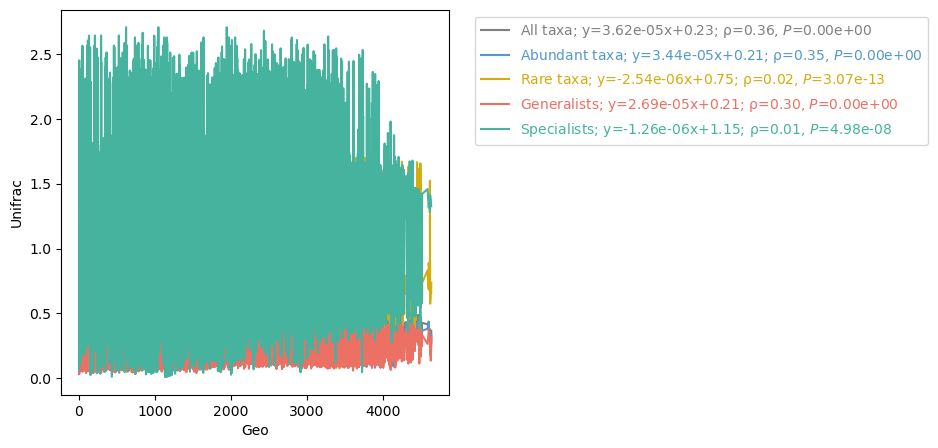

In [58]:
# Use lineplot to get appropriate legend
group_colors = {
    'All': 'grey',
    'Abun': '#5499C7',
    'Rare': '#D4AC0D',
    'Gen': '#EC7063',
    'Spe': '#45B39D'
}

plt.rcParams["figure.figsize"] = (5, 5)

g = sns.lineplot(data=merged_geo_unifrac, x='Geo', y='Unifrac', hue='Group', palette = group_colors)


handles, labels = g.get_legend_handles_labels()

# Custom legend labels using above linear regression equation and spearman correlation
new_labels = ['All taxa; y={0:.2e}x+{1:.2f}; ρ={2:.2f}, $P$={3:.2e}'.format(slope_all,intercept_all, r_all, p_all),
              'Abundant taxa; y={0:.2e}x+{1:.2f}; ρ={2:.2f}, $P$={3:.2e}'.format(slope_abun,intercept_abun, r_abun, p_abun),
              'Rare taxa; y={0:.2e}x+{1:.2f}; ρ={2:.2f}, $P$={3:.2e}'.format(slope_rare,intercept_rare, r_rare, p_rare),
              'Generalists; y={0:.2e}x+{1:.2f}; ρ={2:.2f}, $P$={3:.2e}'.format(slope_gen,intercept_gen, r_gen, p_gen),
              'Specialists; y={0:.2e}x+{1:.2f}; ρ={2:.2f}, $P$={3:.2e}'.format(slope_spe,intercept_spe, r_spe, p_spe)]


legend = g.legend(handles=handles, labels=new_labels, labelcolor=['grey', '#5499C7', '#D4AC0D', '#EC7063', '#45B39D'],
                  loc='upper left', bbox_to_anchor=(1.05, 1))

plt.savefig('../output/distance_decay_ecotypes_legend.pdf', bbox_inches='tight', dpi = 300)
plt.show()

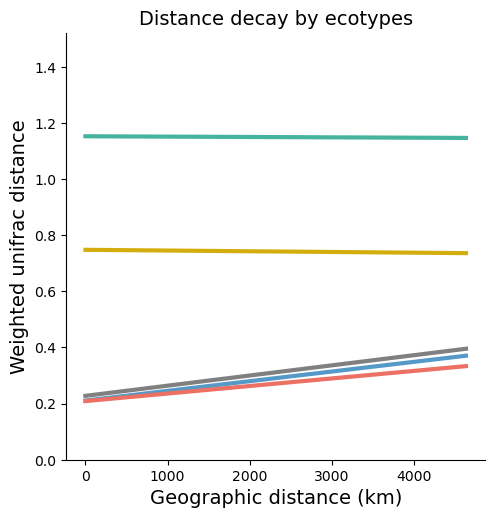

In [44]:
# Plot geographic distance against weighted unifrac distance for ecotypes

plt.rcParams["figure.figsize"] = (5, 5)

g = sns.lmplot(data=merged_geo_unifrac, x='Geo', y='Unifrac', hue='Group', scatter_kws = {'s':0},
               line_kws={'linewidth':3}, palette = group_colors, legend=False)

plt.ylim(0, 1.52)
plt.xlabel('Geographic distance (km)', size=14)
plt.ylabel('Weighted unifrac distance', size=14)
plt.title("Distance decay by ecotypes", size=14)

plt.savefig('../output/distance_decay_ecotypes.pdf', bbox_inches='tight', dpi = 300)
plt.show()

### Ecosystems

In [70]:
# add a Group column to all merged geo unifrac df
merged_geo_unifrac_forest['Group'] = 'Forest'
merged_geo_unifrac_barren['Group'] = 'Barren'
merged_geo_unifrac_wetland['Group'] = 'Wetland'
merged_geo_unifrac_shrubland['Group'] = 'Shrubland'
merged_geo_unifrac_herbaceous['Group'] = 'Herbaceous'
merged_geo_unifrac_steppe['Group'] = 'Steppe'

# Concatenate into one big df
merged_geo_unifrac_eco = pd.concat([merged_geo_unifrac_forest, merged_geo_unifrac_barren,
                                merged_geo_unifrac_wetland, merged_geo_unifrac_shrubland,
                                merged_geo_unifrac_herbaceous, merged_geo_unifrac_steppe])

In [71]:
# Get linear regression equatioin and spearman correlation for each ecosystem
slope_forest, intercept_forest, r_value_forest, p_value_forest, std_err_forest = stats.linregress(merged_geo_unifrac_forest['Geo'], merged_geo_unifrac_forest['Unifrac'])
slope_barren, intercept_barren, r_value_barren, p_value_barren, std_err_barren = stats.linregress(merged_geo_unifrac_barren['Geo'], merged_geo_unifrac_barren['Unifrac'])
slope_wetland, intercept_wetland, r_value_wetland, p_value_wetland, std_err_wetland = stats.linregress(merged_geo_unifrac_wetland['Geo'], merged_geo_unifrac_wetland['Unifrac'])
slope_shrubland, intercept_shrubland, r_value_shrubland, p_value_shrubland, std_err_shrubland = stats.linregress(merged_geo_unifrac_shrubland['Geo'], merged_geo_unifrac_shrubland['Unifrac'])
slope_herbaceous, intercept_herbaceous, r_value_herbaceous, p_value_herbaceous, std_err_herbaceous = stats.linregress(merged_geo_unifrac_herbaceous['Geo'], merged_geo_unifrac_herbaceous['Unifrac'])
slope_steppe, intercept_steppe, r_value_steppe, p_value_steppe, std_err_steppe = stats.linregress(merged_geo_unifrac_steppe['Geo'], merged_geo_unifrac_steppe['Unifrac'])

r_forest, p_forest = stats.spearmanr(merged_geo_unifrac_forest['Geo'], merged_geo_unifrac_forest['Unifrac'])
r_barren, p_barren = stats.spearmanr(merged_geo_unifrac_barren['Geo'], merged_geo_unifrac_barren['Unifrac'])
r_wetland, p_wetland = stats.spearmanr(merged_geo_unifrac_wetland['Geo'], merged_geo_unifrac_wetland['Unifrac'])
r_shrubland, p_shrubland = stats.spearmanr(merged_geo_unifrac_shrubland['Geo'], merged_geo_unifrac_shrubland['Unifrac'])
r_herbaceous, p_herbaceous = stats.spearmanr(merged_geo_unifrac_herbaceous['Geo'], merged_geo_unifrac_herbaceous['Unifrac'])
r_steppe, p_steppe = stats.spearmanr(merged_geo_unifrac_steppe['Geo'], merged_geo_unifrac_steppe['Unifrac'])

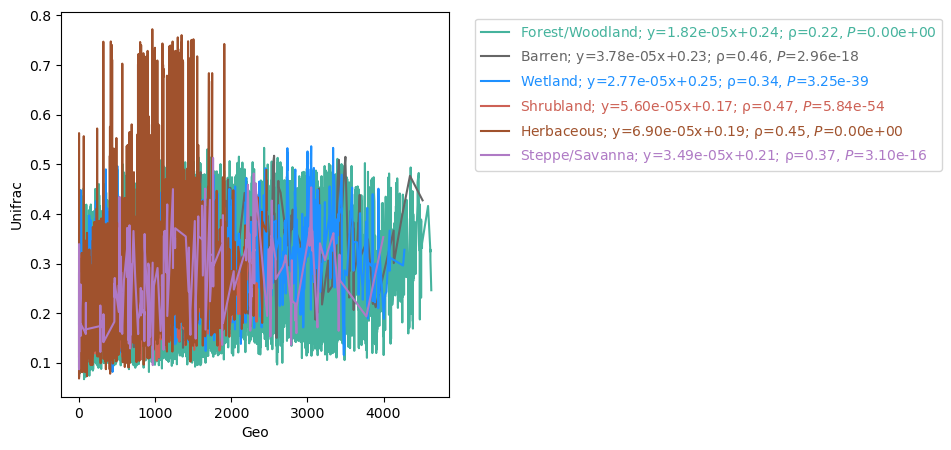

In [74]:
# Use lineplot to get appropriate legend
group_colors = {
    'Forest': '#45B39D',
    'Barren': '#666666',
    'Wetland': '#1E90FF',
    'Shrubland': '#CD6155',
    'Herbaceous': '#A0522D',
    'Steppe': '#AF7AC5'
}

plt.rcParams["figure.figsize"] = (5, 5)

g = sns.lineplot(data=merged_geo_unifrac_eco, x='Geo', y='Unifrac', hue='Group', palette = group_colors)


handles, labels = g.get_legend_handles_labels()

# Custom legend labels using above linear regression equation and spearman correlation
new_labels = ['Forest/Woodland; y={0:.2e}x+{1:.2f}; ρ={2:.2f}, $P$={3:.2e}'.format(slope_forest,intercept_forest, r_forest, p_forest),
              'Barren; y={0:.2e}x+{1:.2f}; ρ={2:.2f}, $P$={3:.2e}'.format(slope_barren,intercept_barren, r_barren, p_barren),
              'Wetland; y={0:.2e}x+{1:.2f}; ρ={2:.2f}, $P$={3:.2e}'.format(slope_wetland,intercept_wetland, r_wetland, p_wetland),
              'Shrubland; y={0:.2e}x+{1:.2f}; ρ={2:.2f}, $P$={3:.2e}'.format(slope_shrubland,intercept_shrubland, r_shrubland, p_shrubland),
              'Herbaceous; y={0:.2e}x+{1:.2f}; ρ={2:.2f}, $P$={3:.2e}'.format(slope_herbaceous,intercept_herbaceous, r_herbaceous, p_herbaceous),
              'Steppe/Savanna; y={0:.2e}x+{1:.2f}; ρ={2:.2f}, $P$={3:.2e}'.format(slope_steppe,intercept_steppe, r_steppe, p_steppe)]


legend = g.legend(handles=handles, labels=new_labels, labelcolor=['#45B39D', '#666666', '#1E90FF', '#CD6155', '#A0522D', '#AF7AC5'],
                  loc='upper left', bbox_to_anchor=(1.05, 1))

plt.savefig('../output/distance_decay_ecosystem_legend.pdf', bbox_inches='tight', dpi = 300)
plt.show()

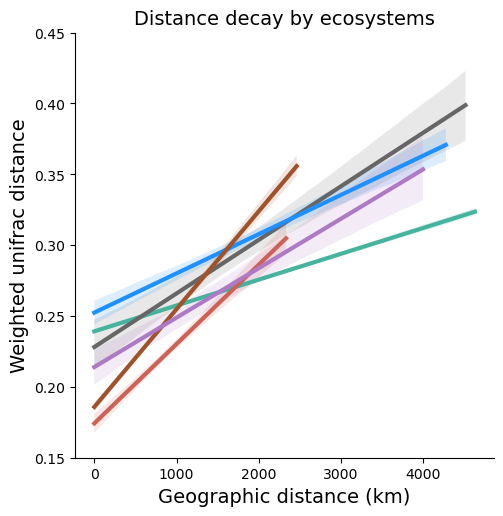

In [75]:
# Plot geographic distance against weighted unifrac distance for ecotypes

plt.rcParams["figure.figsize"] = (5, 5)

g = sns.lmplot(data=merged_geo_unifrac_eco, x='Geo', y='Unifrac', hue='Group', scatter_kws = {'s':0},
               line_kws={'linewidth':3}, palette = group_colors, legend=False)

plt.ylim(0.15, 0.45)
plt.xlabel('Geographic distance (km)', size=14)
plt.ylabel('Weighted unifrac distance', size=14)
plt.title("Distance decay by ecosystems", size=14)

plt.savefig('../output/distance_decay_ecosystems.pdf', bbox_inches='tight', dpi = 300)
plt.show()